In [1]:
import json
import numpy as np
import pandas as pd
import random

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle


from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

In [106]:
file = "../data/renttherunway_final_data.json"
df = pd.read_json(file, lines=True)

In [107]:
# transfer bust size into bust size and cups
df=df.dropna()

# map 'rented for' to numerical value
# change 'party: cocktail' in 'rented for' to 'others'
df.loc[df['rented for'] == 'party: cocktail', df.columns == 'rented for'] = 'party'
df.loc[df['rented for'] == 'work', df.columns == 'rented for'] = 'formal affair'
#df.loc[df['rented for'] == 'wedding', df.columns == 'rented for'] = 'formal affair'

labels = df['rented for'].astype('category').cat.categories.tolist()
replace_map = {'rented for' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print('--- map rented for to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)

df['cups'] = df['bust size'].str.extract(r'([a-z])')
labels = df['cups'].astype('category').cat.categories.tolist()
replace_map = {'cups' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print('--- map cups to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)
df['bust size'] = df['bust size'].str.extract('(\d+)').astype(int)
# remove lbs after 'weight'
df['weight'] = df['weight'].str.extract('(\d+)').astype(int)
# parse height to usable numerical format
def parse_height(ht):
    ht_ = ht.split("' ")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_
df['height'] = df['height'].apply(lambda x:parse_height(x))

--- map rented for to numerical value ---
{'rented for': {'date': 1, 'everyday': 2, 'formal affair': 3, 'other': 4, 'party': 5, 'vacation': 6, 'wedding': 7}}
--- map cups to numerical value ---
{'cups': {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9}}


In [111]:
df=df.drop(columns=['user_id', 'item_id','review_date','review_summary','review_text','fit'])

In [112]:
df.loc[df['category'].isin(['sweater','shirt','blouse','vest','tank','tunic','print','sweatshirt',
                            'tee','blouson','turtleneck','hoodie','t-shirt','cami','crewneck',
                            'buttondown','sweatershirt'
                           ]),df.columns=='category']='tops'
df.loc[df['category'].isin(['pants','down','culottes','pant','trouser','culotte','jogger',
                            'trousers','jeans', 'sweatpants'
                           ]),df.columns=='category']='bottoms'
df.loc[df['category'].isin(['ballgown']),df.columns=='category']='gown'
df.loc[df['category'].isin(['leggings','legging']),df.columns=='category']='active'
df.loc[df['category'].isin(['jacket','trench','cape','bomber','blazer','duster','poncho',
                            'cardigan','peacoat','pullover','overcoat','parka'
                           ]),df.columns=='category']='coat'
df.loc[df['category'].isin(['mini','midi','skirts']),df.columns=='category']='skirt'
df.loc[df['category'].isin(['jumpsuit']),df.columns=='category']='romper'
df.loc[df['category'].isin(['sheath','shift','maxi','shirtdress','frock','kaftan','caftan'
                           ]),df.columns=='category']='dress'
df.loc[df['category'].isin(['overalls','combo','henley','tight','kimono','for','skort']),df.columns=='category']='other'

In [113]:
df.info()
df= pd.get_dummies(df, columns=['body type','category'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146381 entries, 0 to 192543
Data columns (total 10 columns):
age           146381 non-null float64
body type     146381 non-null object
bust size     146381 non-null int64
category      146381 non-null object
height        146381 non-null float64
rating        146381 non-null float64
rented for    146381 non-null int64
size          146381 non-null int64
weight        146381 non-null int64
cups          146381 non-null int64
dtypes: float64(3), int64(5), object(2)
memory usage: 12.3+ MB


In [37]:
df.dtypes

age                            float64
bust size                        int64
height                         float64
rating                         float64
rented for                       int64
size                             int64
weight                           int64
cups                             int64
body type_apple                  uint8
body type_athletic               uint8
body type_full bust              uint8
body type_hourglass              uint8
body type_pear                   uint8
body type_petite                 uint8
body type_straight & narrow      uint8
category_active                  uint8
category_bottoms                 uint8
category_coat                    uint8
category_dress                   uint8
category_gown                    uint8
category_knit                    uint8
category_other                   uint8
category_romper                  uint8
category_skirt                   uint8
category_suit                    uint8
category_top             

In [110]:
df['rented for'].value_counts()

7    42622
3    42620
5    27199
2    13263
4    11510
1     5929
6     3238
Name: rented for, dtype: int64

In [119]:
df['rented for'].unique()

array([6, 4, 3, 7, 1, 2, 5])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a52d73160>]],
      dtype=object)

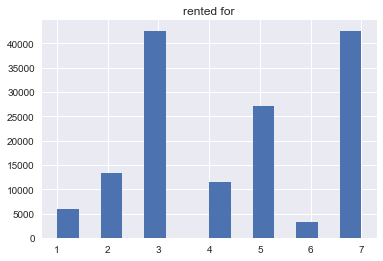

In [122]:
df.hist(column='rented for',bins=14)

In [39]:
X = df.drop(columns=['rented for'], axis=1)
y = df['rented for']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
y_test[:5]

149201    3
2482      3
85833     3
8413      3
82576     5
Name: rented for, dtype: int64

In [44]:
# Logistic regression 
lg = LogisticRegression(multi_class='ovr').fit(X_train, y_train)
pred_train = lg.predict(X_train)
pred_test = lg.predict(X_test)
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_test, pred_test))

0.6142442008666836
0.6144371299631516


In [59]:
C_value = [0.01, 0.1, 1, 5, 10]
for c in C_value:
    lg = LogisticRegression(multi_class='ovr', C=c, random_state=42).fit(X_train, y_train)
    pred_train = lg.predict(X_train)
    pred_test = lg.predict(X_test)
    print('current c value {}'.format(c))
    print(accuracy_score(y_train, pred_train))
    print(accuracy_score(y_test, pred_test))

current c value 0.01
0.6129696660718837
0.6134227632178197
current c value 0.1
0.6141932194748917
0.6144785326874508
current c value 1
0.6142442008666836
0.6144371299631516
current c value 5
0.6141116492480244
0.6144785326874508
current c value 10
0.6141932194748917
0.6144785326874508


In [53]:
depth = [1, 5, 10, 15, 20, 30]
# Decision Tree
for d in depth:
    dt = DecisionTreeClassifier(random_state=42, max_depth=d).fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    pred_test = dt.predict(X_test)
    print('current depth {}'.format(d))
    print(accuracy_score(y_train, pred_train))
    print(accuracy_score(y_test, pred_test))

current depth 1
0.5830028039765486
0.5809630273672007
current depth 5
0.6137037981136885
0.6139609986337101
current depth 10
0.621534539892939
0.6118701610565975
current depth 15
0.6626459342340046
0.5961371258228791
current depth 20
0.748580168238593
0.5676934542292883
current depth 30
0.9067550344124394
0.511344346457997


In [60]:
# Random Forest Classification
depth = [1, 5, 10, 15, 20, 30]
for d in depth:
    rf = RandomForestClassifier(random_state=42, max_depth=d).fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    pred_test = rf.predict(X_test)
    print('current depth {}'.format(d))
    print(accuracy_score(y_train, pred_train))
    print(accuracy_score(y_test, pred_test))

current depth 1
0.5830028039765486
0.5809630273672007
current depth 5
0.6053836349732348
0.6026580549000125
current depth 10
0.6165995411674738
0.6120564733159441
current depth 15
0.6509711955136375
0.6148097544818449
current depth 20
0.7316543461636502
0.6072744586593798
current depth 30
0.9016059138414478
0.5820601995611311


In [56]:
# Gradient Boosting Classification
depth = [1, 5, 10, 15, 20, 30]
for d in depth:
    gb = GradientBoostingClassifier(random_state=42, max_depth=d).fit(X_train, y_train)
    pred_train = gb.predict(X_train)
    pred_test = gb.predict(X_test)
    print('current depth {}'.format(d))
    print(accuracy_score(y_train, pred_train))
    print(accuracy_score(y_test, pred_test))

current depth 1
0.6135202651032373
0.6135262700285679
current depth 5
0.6253479479989804
0.6163623566430672
current depth 10
0.7307366811113943
0.6141266095309071
current depth 15
0.9236298750955901
0.5893263776756511
current depth 20
0.9399643130257456
0.5782925516498986
current depth 30
0.9399643130257456
0.5694737713741564


In [61]:
import nltk
import string
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer

In [62]:
from sklearn import linear_model

In [63]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meiyihe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [64]:
len(set(stopwords.words('english')))

179

In [66]:
file = "../data/renttherunway_final_data.json"
df = pd.read_json(file, lines=True)

In [67]:
df.head()

,age,body type,bust size,category,fit,height,item_id,rating,rented for,review_date,review_summary,review_text,size,user_id,weight
0,28.0,hourglass,34d,romper,fit,"5' 8""",2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137lbs
1,36.0,straight & narrow,34b,gown,fit,"5' 6""",153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132lbs
2,116.0,NaN,NaN,sheath,fit,"5' 4""",1063761,10.0,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,NaN
3,34.0,pear,34c,dress,fit,"5' 5""",126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135lbs
4,27.0,athletic,34b,gown,fit,"5' 9""",616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145lbs


In [68]:
# transfer bust size into bust size and cups
df=df.dropna()

# map 'rented for' to numerical value
# change 'party: cocktail' in 'rented for' to 'others'
df.loc[df['rented for'] == 'party: cocktail', df.columns == 'rented for'] = 'party'
df.loc[df['rented for'] == 'work', df.columns == 'rented for'] = 'formal affair'
df.loc[df['rented for'] == 'wedding', df.columns == 'rented for'] = 'formal affair'

labels = df['rented for'].astype('category').cat.categories.tolist()
replace_map = {'rented for' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}


# strip punctuations
review = []
table = str.maketrans({key: None for key in string.punctuation})
for idx, row in df.iterrows():
    tmp = row['review_summary'] + " " +row['review_text']
    tmp = tmp.translate(table)
    review.append(tmp)
    
#df_y = df['rented for'].values

In [70]:
print('--- map rented for to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)
df_y = df['rented for'].values
df_y[:5]

--- map rented for to numerical value ---
{'rented for': {'date': 1, 'everyday': 2, 'formal affair': 3, 'other': 4, 'party': 5, 'vacation': 6}}


array([6, 4, 3, 3, 1])

In [71]:
review[0]

'So many compliments An adorable romper Belt and zipper were a little hard to navigate in a full day of wearbathroom use but thats to be expected Wish it had pockets but other than that absolutely perfect I got a million compliments'

In [72]:
# count how many unique words in the whole review pool
punctuation = set(string.punctuation)
r = ''.join([c.lower() for c in review if not c in punctuation])
s = set(r.split( ))
print(len(s))

78189


In [73]:
# let's try text mining + prediction here
def getTopWords(data, num):
    stemmer = PorterStemmer()
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    r = ''.join([c.lower() for c in data if not c in punctuation])
    for w in r.split():
        if w not in stopwords.words("english"):
            w = stemmer.stem(w)
            wordCount[w] += 1
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort(reverse=True)
    print(counts[:10])
    wordList = [x[1] for x in counts[:num]]
        
    return wordList, counts

In [74]:
wordList, counts = getTopWords(review, 100)

[(261898, 'dress'), (97198, 'fit'), (71320, 'wear'), (69822, 'size'), (60281, 'love'), (53683, 'would'), (52871, 'great'), (51695, 'perfect'), (51342, 'wore'), (47691, 'compliment')]


In [75]:
wholeList = [x[1] for x in counts]

In [76]:
len(wholeList)

67597

In [77]:
# return feature array of the text review
def getFeature(topWords, text):
    feat = [1]
    rev = text.lower()
    
    for i in range(len(topWords)):
        if topWords[i].lower() in rev:
            feat.append(rev.count(topWords[i]))
        else:
            feat.append(0)
    return feat

In [78]:
# construct feature array, build df_X
topWords = wholeList[:5000]
df_X = []
for i in review:
    df_X.append(getFeature(topWords, i))

In [79]:
df_X[0][:20]

[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0]

In [80]:
# add tf-idf transformer
tfidf = TfidfTransformer(sublinear_tf=True)
df_X = tfidf.fit_transform(df_X)
df_X = df_X.toarray()

In [81]:
df_X[0][:20]

array([0.03150945, 0.        , 0.        , 0.06235305, 0.        ,
       0.        , 0.        , 0.        , 0.06266221, 0.        ,
       0.11456476, 0.        , 0.07609793, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08307328, 0.        ])

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state=42 )

In [83]:
# ridge classifier 
clf = linear_model.RidgeClassifier(fit_intercept=False)
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
print(accuracy_score(y_train, pred_train))

pred_test = clf.predict(X_test)
print(accuracy_score(y_test, pred_test))

0.7090288044863625
0.6914047944354739


In [95]:
C_value = [0.01, 0.1, 1, 5, 10]
train_acc = []
test_acc = []
for c in C_value:
    lg = LogisticRegression(multi_class='ovr', C=c, random_state=42).fit(X_train, y_train)
    pred_train = lg.predict(X_train)
    pred_test = lg.predict(X_test)
    print('current c value {}'.format(c))
    tmp_train = accuracy_score(y_train, pred_train)
    tmp_test = accuracy_score(y_test, pred_test)
    print(tmp_train)
    print(tmp_test)
    train_acc.append(tmp_train)
    test_acc.append(tmp_test)

current c value 0.01
0.6078307417792506
0.6054113360659131
current c value 0.1
0.673790466479735
0.6681778661035896
current c value 1
0.7092633188886056
0.6954622614168012
current c value 5
0.7225388733112414
0.6971390717509212
current c value 10
0.7271985725210298
0.6962696145406367


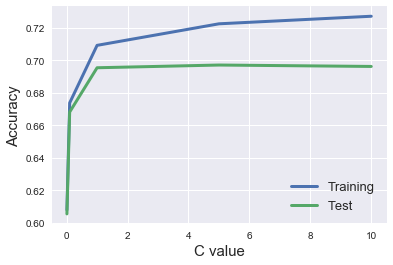

In [98]:
import seaborn as sns
sns.set()

#fig = plt.figure()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.plot(C_value, train_acc, label='Training', linewidth=3)
plt.plot(C_value, test_acc, label='Test', linewidth=3)
plt.xlabel('C value', fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(loc='best', fontsize=13)

In [85]:
depth = [1, 5, 10, 15, 20, 30]
train_acc = []
test_acc = []
# Decision Tree
for d in depth:
    dt = DecisionTreeClassifier(random_state=42, max_depth=d).fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    pred_test = dt.predict(X_test)
    print('current depth {}'.format(d))
    tmp_train = accuracy_score(y_train, pred_train)
    tmp_test = accuracy_score(y_test, pred_test)
    print(tmp_train)
    print(tmp_test)
    train_acc.append(tmp_train)
    test_acc.append(tmp_test)
    
fig = plt.figure()

plt.plot(C_value, train_acc, color='b', label='train acc')
plt.plot(C_value, test_acc, color='r', label='test acc')
plt.xlabel('C value')
plt.xlabel('Accuracy')
plt.legend()

current depth 1
0.608860565893449
0.6054527387902124
current depth 5
0.6298037216416008
0.6238976524655322
current depth 10
0.6703033392811624
0.6490291061151824
current depth 15
0.7118327810349222
0.6503539932927587
current depth 20
0.7515472852408871
0.6468554630894713
current depth 30
0.8266734641855723
0.6293421107108848


current depth 20
0.6633086923273005
0.62402186063843
current depth 30
0.7519245475401478
0.638719827764667
current depth 40
0.8357481519245475
0.6431085165403884
current depth 50
0.9041141983176141
0.6414731089305676
current depth 60
0.9381493754779505
0.6409348735146773


Text(0.5,0,'Accuracy')

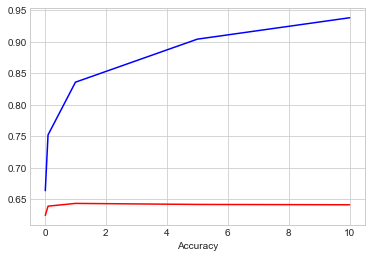

In [94]:
# Random Forest Classification
depth = [20, 30, 40, 50, 60]
train_acc = []
test_acc = []
for d in depth:
    rf = RandomForestClassifier(random_state=42, max_depth=d).fit(X_train, y_train)
    pred_train = rf.predict(X_train)
    pred_test = rf.predict(X_test)
    print('current depth {}'.format(d))
    tmp_train = accuracy_score(y_train, pred_train)
    tmp_test = accuracy_score(y_test, pred_test)
    print(tmp_train)
    print(tmp_test)
    train_acc.append(tmp_train)
    test_acc.append(tmp_test)
    
fig = plt.figure()

plt.plot(C_value, train_acc, color='b', label='train acc')
plt.plot(C_value, test_acc, color='r', label='test acc')
plt.xlabel('C value')
plt.xlabel('Accuracy')

In [99]:
# Gradient Boosting Classification
# depth = [1, 5, 10, 15, 20, 30]
# for d in depth:
#     gb = GradientBoostingClassifier(random_state=42, max_depth=d).fit(X_train, y_train)
#     pred_train = gb.predict(X_train)
#     pred_test = gb.predict(X_test)
#     print('current depth {}'.format(d))
#     print(accuracy_score(y_train, pred_train))
#     print(accuracy_score(y_test, pred_test))

In [7]:
# Pre-process Data 

# print original data shape
print(df.shape)
# drop NANs 
df = df.dropna()
print(df.shape)
# map 'body type' to numerical value
labels = df['body type'].astype('category').cat.categories.tolist()
replace_map = {'body type' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print('--- map body type to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)

# remove the string after 'bust size'
df['bust size'] = df['bust size'].str.extract('(\d+)').astype(int)

# parse height to usable numerical format
def parse_height(ht):
    ht_ = ht.split("' ")
    ft_ = float(ht_[0])
    in_ = float(ht_[1].replace("\"",""))
    return (12*ft_) + in_
df['height'] = df['height'].apply(lambda x:parse_height(x))

# map 'category' to numerical value
# ------ I think this part needs more cleansing -----
labels = df['category'].astype('category').cat.categories.tolist()
replace_map = {'category' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print('--- map category to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)


# map 'fit' to numerical value
labels = df['fit'].astype('category').cat.categories.tolist()
replace_map = {'fit' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print('--- map fit to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)

# remove strings after ':' in 'party: cocktail'
df['rented for'] = df['rented for'].str.split(':').str[0]

# remove lbs after 'weight'
df['weight'] = df['weight'].str.extract('(\d+)').astype(int)


# map 'rented for' to numerical value
labels = df['rented for'].astype('category').cat.categories.tolist()
replace_map = {'rented for' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
print('--- map rented for to numerical value ---')
print(replace_map)
df.replace(replace_map, inplace=True)

(192544, 15)
(146381, 15)
--- map body type to numerical value ---
{'body type': {'apple': 1, 'athletic': 2, 'full bust': 3, 'hourglass': 4, 'pear': 5, 'petite': 6, 'straight & narrow': 7}}
--- map category to numerical value ---
{'category': {'ballgown': 1, 'blazer': 2, 'blouse': 3, 'blouson': 4, 'bomber': 5, 'buttondown': 6, 'caftan': 7, 'cami': 8, 'cape': 9, 'cardigan': 10, 'coat': 11, 'combo': 12, 'crewneck': 13, 'culotte': 14, 'culottes': 15, 'down': 16, 'dress': 17, 'duster': 18, 'for': 19, 'frock': 20, 'gown': 21, 'henley': 22, 'hoodie': 23, 'jacket': 24, 'jeans': 25, 'jogger': 26, 'jumpsuit': 27, 'kaftan': 28, 'kimono': 29, 'knit': 30, 'legging': 31, 'leggings': 32, 'maxi': 33, 'midi': 34, 'mini': 35, 'overalls': 36, 'overcoat': 37, 'pant': 38, 'pants': 39, 'parka': 40, 'peacoat': 41, 'poncho': 42, 'print': 43, 'pullover': 44, 'romper': 45, 'sheath': 46, 'shift': 47, 'shirt': 48, 'shirtdress': 49, 'skirt': 50, 'skirts': 51, 'skort': 52, 'suit': 53, 'sweater': 54, 'sweatershirt'

In [36]:
#df.head()

In [18]:
df.dtypes

age               float64
body type           int64
bust size           int64
category            int64
fit                 int64
height            float64
item_id             int64
rating            float64
rented for          int64
review_date        object
review_summary     object
review_text        object
size                int64
user_id             int64
weight              int64
dtype: object

In [8]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)

In [9]:
len(df_train)

98075

In [10]:
label = 'rating'

X_train = df_train.drop([label, 'review_date','review_summary', 'review_text'],axis=1)
y_train = df_train[label]
X_test = df_test.drop([label, 'review_date','review_summary', 'review_text'],axis=1)
y_test = df_test[label]

In [11]:
X_train.head()

,age,body type,bust size,category,fit,height,item_id,rented for,size,user_id,weight
114785,37.0,4,34,46,1,67.0,1851598,5,8,516231,135
126377,32.0,4,32,17,1,64.0,174391,3,1,254634,130
117721,37.0,2,34,17,1,65.0,1316534,8,8,995881,130
167358,35.0,2,34,17,1,66.0,1055399,8,8,87081,130
97435,28.0,4,36,21,1,64.0,242782,3,24,838084,155


In [12]:
# import machine learning models
from sklearn.ensemble import RandomForestClassifier

In [13]:
clf = RandomForestClassifier(criterion = 'entropy', random_state = 42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [14]:
pred_test = clf.predict(X_test)
accuracy_score(y_test, pred_test)

# probably needs text mining instead of using other features

0.596758166687368